In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
# setup device and random seeds for reproducible results
# this ensures we get the same results every time we run the code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

Using device: cpu


/home/mgachlo/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# count trainable parameters in a model
# this helps us compare models fairly by ensuring similar complexity
def count_parameters(model):
    """Count trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# target function: sin(5πx)/(5πx)
# we add small epsilon to avoid division by zero at x=0
def target_function(x):
    """Target function: sin(5πx)/(5πx)"""
    return torch.sin(5 * math.pi * x) / (5 * math.pi * x + 1e-8)

In [ ]:
# model architectures with same parameter count
# we want to compare depth vs width while keeping total parameters similar
class ShallowNet(nn.Module):
     # simple 3-layer network with wide hidden layers
    # fewer layers but more neurons per layer
    def __init__(self, hidden_size=50):
        super(ShallowNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [ ]:
class DeepNet(nn.Module):
    def __init__(self, hidden_size=28):  
        # deeper 6-layer network with narrower hidden layers
        # more layers but fewer neurons per layer
        super(DeepNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [ ]:
class VeryDeepNet(nn.Module):
     # very deep 9-layer network with even narrower layers
    # tests if even more depth helps with function approximation
    def __init__(self, hidden_size=22):  
        super(VeryDeepNet, self).__init__()
        layers = [nn.Linear(1, hidden_size), nn.ReLU()]
        for _ in range(7):  
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [ ]:
def train_function_model(model, train_loader, epochs=5000, lr=0.001):
    # train model on function approximation task
    # we use adam optimizer which usually works well for neural networks
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')
    
    return losses

In [9]:
# Generate training data
x_train = torch.linspace(-2, 2, 1000).unsqueeze(1)
y_train = target_function(x_train)
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [10]:
#x_train

In [11]:
#y_train

In [12]:
train_dataset

In [13]:
train_loader

In [14]:
# Generate test data for visualization
x_test = torch.linspace(-2, 2, 500).unsqueeze(1)
y_test = target_function(x_test)

In [15]:
#x_test

In [16]:
#y_test

In [17]:
# Initialize models
shallow_net = ShallowNet(hidden_size=50).to(device)
shallow_net

ShallowNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [18]:
deep_net = DeepNet(hidden_size=28).to(device)
deep_net

DeepNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=28, bias=True)
    (3): ReLU()
    (4): Linear(in_features=28, out_features=28, bias=True)
    (5): ReLU()
    (6): Linear(in_features=28, out_features=28, bias=True)
    (7): ReLU()
    (8): Linear(in_features=28, out_features=28, bias=True)
    (9): ReLU()
    (10): Linear(in_features=28, out_features=1, bias=True)
  )
)

In [19]:
very_deep_net = VeryDeepNet(hidden_size=22).to(device)
very_deep_net

VeryDeepNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=22, bias=True)
    (1): ReLU()
    (2): Linear(in_features=22, out_features=22, bias=True)
    (3): ReLU()
    (4): Linear(in_features=22, out_features=22, bias=True)
    (5): ReLU()
    (6): Linear(in_features=22, out_features=22, bias=True)
    (7): ReLU()
    (8): Linear(in_features=22, out_features=22, bias=True)
    (9): ReLU()
    (10): Linear(in_features=22, out_features=22, bias=True)
    (11): ReLU()
    (12): Linear(in_features=22, out_features=22, bias=True)
    (13): ReLU()
    (14): Linear(in_features=22, out_features=22, bias=True)
    (15): ReLU()
    (16): Linear(in_features=22, out_features=1, bias=True)
  )
)

In [20]:
# Train models
shallow_losses = train_function_model(shallow_net, train_loader, epochs=3000)

Epoch 0, Loss: 0.042584
Epoch 1000, Loss: 0.000329
Epoch 2000, Loss: 0.000058


In [21]:
deep_losses = train_function_model(deep_net, train_loader, epochs=3000)

Epoch 0, Loss: 0.044574
Epoch 1000, Loss: 0.000040
Epoch 2000, Loss: 0.000016


In [22]:
very_deep_losses = train_function_model(very_deep_net, train_loader, epochs=3000)

Epoch 0, Loss: 0.046614
Epoch 1000, Loss: 0.000020
Epoch 2000, Loss: 0.000003


In [23]:
# Generate predictions
shallow_net.eval()
deep_net.eval()
very_deep_net.eval()

VeryDeepNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=22, bias=True)
    (1): ReLU()
    (2): Linear(in_features=22, out_features=22, bias=True)
    (3): ReLU()
    (4): Linear(in_features=22, out_features=22, bias=True)
    (5): ReLU()
    (6): Linear(in_features=22, out_features=22, bias=True)
    (7): ReLU()
    (8): Linear(in_features=22, out_features=22, bias=True)
    (9): ReLU()
    (10): Linear(in_features=22, out_features=22, bias=True)
    (11): ReLU()
    (12): Linear(in_features=22, out_features=22, bias=True)
    (13): ReLU()
    (14): Linear(in_features=22, out_features=22, bias=True)
    (15): ReLU()
    (16): Linear(in_features=22, out_features=1, bias=True)
  )
)

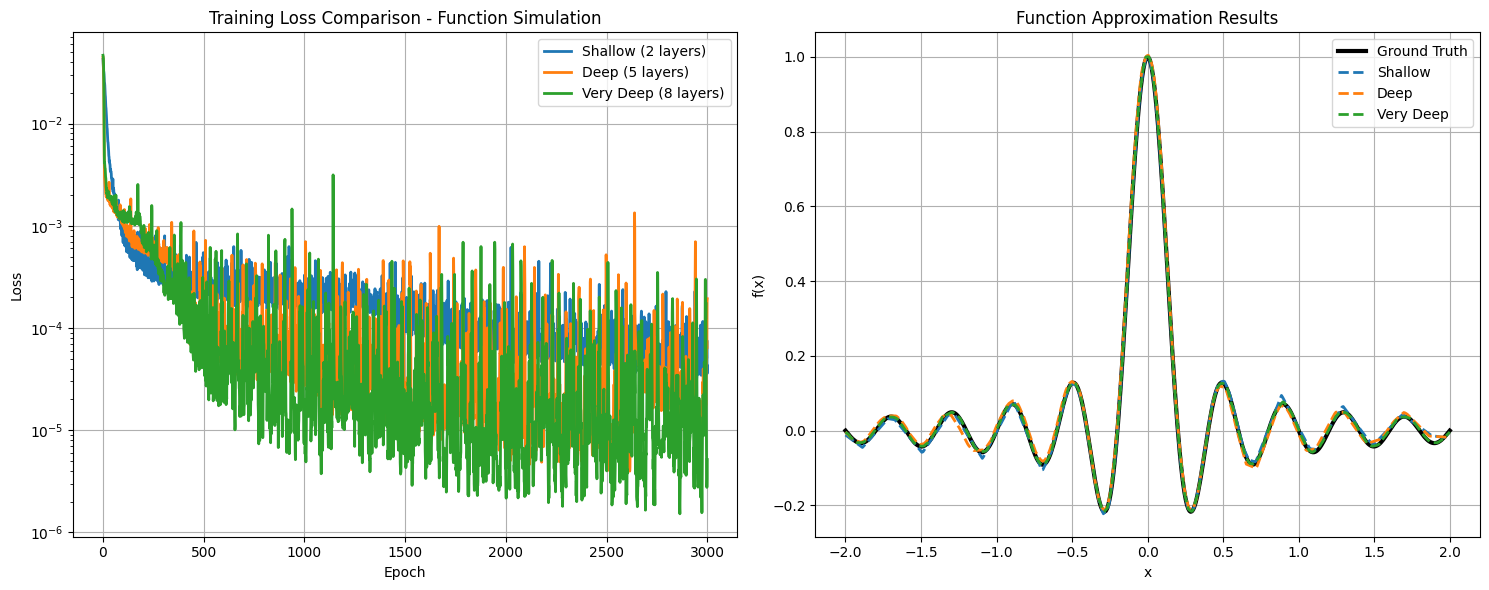

In [24]:
with torch.no_grad():
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    shallow_pred = shallow_net(x_test)
    deep_pred = deep_net(x_test)
    very_deep_pred = very_deep_net(x_test)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training loss curves
ax1.plot(shallow_losses, label='Shallow (2 layers)', linewidth=2)
ax1.plot(deep_losses, label='Deep (5 layers)', linewidth=2)
ax1.plot(very_deep_losses, label='Very Deep (8 layers)', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison - Function Simulation')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True)

# Function predictions
x_test_cpu = x_test.cpu()
y_test_cpu = y_test.cpu()
shallow_pred_cpu = shallow_pred.cpu()
deep_pred_cpu = deep_pred.cpu()
very_deep_pred_cpu = very_deep_pred.cpu()

ax2.plot(x_test_cpu.numpy(), y_test_cpu.numpy(), 'k-', label='Ground Truth', linewidth=3)
ax2.plot(x_test_cpu.numpy(), shallow_pred_cpu.numpy(), '--', label='Shallow', linewidth=2)
ax2.plot(x_test_cpu.numpy(), deep_pred_cpu.numpy(), '--', label='Deep', linewidth=2)
ax2.plot(x_test_cpu.numpy(), very_deep_pred_cpu.numpy(), '--', label='Very Deep', linewidth=2)
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.set_title('Function Approximation Results')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
#plt.savefig('function_simulation_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Calculate final MSE
with torch.no_grad():
    shallow_mse = nn.MSELoss()(shallow_pred, y_test).item()
    deep_mse = nn.MSELoss()(deep_pred, y_test).item()
    very_deep_mse = nn.MSELoss()(very_deep_pred, y_test).item()

print(f"Shallow Network: {shallow_mse:.6f}")
print(f"Deep Network: {deep_mse:.6f}")
print(f"Very Deep Network: {very_deep_mse:.6f}")

Shallow Network: 0.000054
Deep Network: 0.000153
Very Deep Network: 0.000004


# MNIST dataset

In [ ]:
# prepare mnist data with standard normalization
# normalization helps neural networks train more effectively
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader_mnist = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# cnn models for image classification
# cnns work better than fully connected networks for images
class ShallowCNN(nn.Module):
     # simple cnn with just 2 convolutional layers
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class DeepCNN(nn.Module):
    # deeper cnn with more convolutional layers
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [29]:
def train_and_evaluate_mnist(model, model_name, epochs=20):
    """Train and evaluate MNIST model"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    print(f"\nTraining {model_name}...")
    print(f"Parameters: {count_parameters(model)}")

In [30]:
def train_and_evaluate_mnist(model, model_name, epochs=20):
    """Train and evaluate MNIST model"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    print(f"\nTraining {model_name}...")
    print(f"Parameters: {count_parameters(model)}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for data, target in train_loader_mnist:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        avg_train_loss = train_loss / len(train_loader_mnist)
        train_accuracy = 100.0 * train_correct / train_total
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader_mnist:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()
        
        avg_test_loss = test_loss / len(test_loader_mnist)
        test_accuracy = 100.0 * test_correct / test_total
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }


In [31]:
# Train all MNIST models
models_mnist = [
    (ShallowCNN(), "Shallow CNN"),
    (DeepCNN(), "Deep CNN"),
]

In [32]:
results_mnist = {}
for model, name in models_mnist:
    results_mnist[name] = train_and_evaluate_mnist(model, name, epochs=20)


Training Shallow CNN...
Parameters: 454922
Epoch 0: Train Acc: 94.71%, Test Acc: 98.74%
Epoch 5: Train Acc: 99.16%, Test Acc: 99.30%
Epoch 10: Train Acc: 99.44%, Test Acc: 99.35%
Epoch 15: Train Acc: 99.54%, Test Acc: 99.47%

Training Deep CNN...
Parameters: 146938
Epoch 0: Train Acc: 88.52%, Test Acc: 98.22%
Epoch 5: Train Acc: 98.82%, Test Acc: 98.98%
Epoch 10: Train Acc: 99.23%, Test Acc: 99.49%
Epoch 15: Train Acc: 99.44%, Test Acc: 99.41%


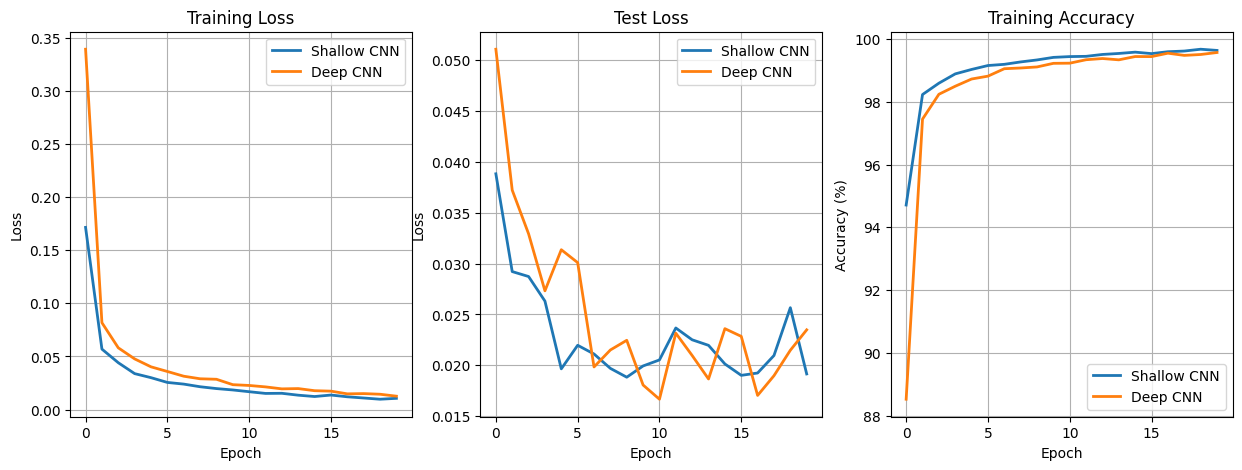

In [33]:
# Plot MNIST results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Training Loss
for name, result in results_mnist.items():
    axes[0].plot(result['train_losses'], label=name, linewidth=2)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Test Loss
for name, result in results_mnist.items():
    axes[1].plot(result['test_losses'], label=name, linewidth=2)
axes[1].set_title('Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Training Accuracy
for name, result in results_mnist.items():
    axes[2].plot(result['train_accuracies'], label=name, linewidth=2)
axes[2].set_title('Training Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].legend()
axes[2].grid(True)